# T81-558: Applications of Deep Neural Networks
**Module 4: Training for Tabular Data**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 4 Material

* Part 4.1: Encoding a Feature Vector for Keras Deep Learning [[Video]](https://www.youtube.com/watch?v=Vxz-gfs9nMQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_04_01_feature_encode.ipynb)
* Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC [[Video]](https://www.youtube.com/watch?v=-f3bg9dLMks&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_04_02_multi_class.ipynb)
* **Part 4.3: Keras Regression for Deep Neural Networks with RMSE** [[Video]](https://www.youtube.com/watch?v=wNhBUC6X5-E&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_04_03_regression.ipynb)
* Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training [[Video]](https://www.youtube.com/watch?v=VbDg8aBgpck&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_04_04_backprop.ipynb)
* Part 4.5: Neural Network RMSE and Log Loss Error Calculation from Scratch [[Video]](https://www.youtube.com/watch?v=wmQX1t2PHJc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_04_05_rmse_logloss.ipynb)

# Part 4.3: Keras Regression for Deep Neural Networks with RMSE

Regression results are evaluated differently than classification.  Consider the following code that trains a neural network for regression on the data set **jh-simple-dataset.csv**.  

In [24]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

# Create train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 1500 samples, validate on 500 samples
Epoch 1/1000
1500/1500 - 0s - loss: 1834.4746 - val_loss: 1555.7496
Epoch 2/1000
1500/1500 - 0s - loss: 1128.6225 - val_loss: 596.7848
Epoch 3/1000
1500/1500 - 0s - loss: 309.0902 - val_loss: 216.0889
Epoch 4/1000
1500/1500 - 0s - loss: 198.5140 - val_loss: 175.7933
Epoch 5/1000
1500/1500 - 0s - loss: 161.8848 - val_loss: 143.2645
Epoch 6/1000
1500/1500 - 0s - loss: 129.9777 - val_loss: 115.8634
Epoch 7/1000
1500/1500 - 0s - loss: 104.1696 - val_loss: 94.5874
Epoch 8/1000
1500/1500 - 0s - loss: 84.0263 - val_loss: 76.9275
Epoch 9/1000
1500/1500 - 0s - loss: 67.3906 - val_loss: 63.3016
Epoch 10/1000
1500/1500 - 0s - loss: 53.9733 - val_loss: 52.5729
Epoch 11/1000
1500/1500 - 0s - loss: 43.7616 - val_loss: 43.5526
Epoch 12/1000
1500/1500 - 0s - loss: 35.4615 - val_loss: 36.0342
Epoch 13/1000
1500/1500 - 0s - loss: 28.9388 - val_loss: 29.8219
Epoch 14/1000
1500/1500 - 0s - loss: 23.6070 - val_loss: 24.7436
Epoch 15/1000
1500/1500 - 0s - loss:

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.  Low MSE values are desired.

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [26]:
from sklearn import metrics

# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.45591977942858647


### Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE.  Because of this, the RMSE error is in the same units as the training data outcome. Low RMSE values are desired.

$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [27]:
import numpy as np

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.6752183198259556


### Lift Chart


To generate a lift chart, perform the following activities:

* Sort the data by expected output. Plot the blue line above.
* For every point on the x-axis plot the predicted value for that same data point. This is the green line above.
* The x-axis is just 0 to 100% of the dataset. The expected always starts low and ends high.
* The y-axis is ranged according to the values predicted.

Reading a lift chart:

* The expected and predict lines should be close. Notice where one is above the ot other.
* The below chart is the most accurate on lower age.

In [28]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

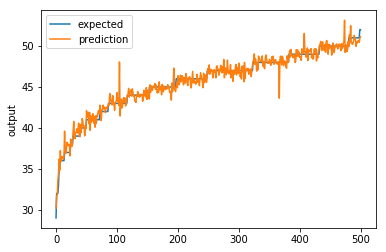

In [29]:
# Plot the chart
chart_regression(pred.flatten(),y_test)